# Regresión lineal simple

#### <div style="text-align: right">Berenice Montalvo Lezama</div>

[TensorFlow](https://www.tensorflow.org/beta) es una biblioteca de software de código abierto para la implementación eficiente, rápida y sencilla de redes neuronales profundas. En este curso se utilizará la version TensorFlow 2.0. Beta.

Para comenzar a familiarizarnos con TensorFlow implementaremos un modelo de regresión lineal simple sobre un conjunto de datos de calificaciones, lo que deseamos predecir es que calificación tendrá el alumno en un examen. El conjunto de datos posee dos atributos entrada: la calificación que obtuvo en un examen previo y el número de horas que estudio el alumno para presentar el examen. En este ejemplo nos enfocaremos en realizar regresion lineal univariada, por lo tanto, consideraremos únicamente un atributo de entrada, el número de horas de estudio.




In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model

# para reproducibilidad
tf.random.set_seed(2019)

## Carga de datos

Utilizamos [Pandas](https://pandas.pydata.org/) para la lectura del csv e imprimimos los primeros 5 ejemplos.


In [2]:
df = pd.read_csv('../data/califs/califs.csv', names=['calif anterior','horas de estudio','calificación'])
df.head(5)

,calif anterior,horas de estudio,calificación
0,5.638,8.289,5.136
1,6.744,9.389,5.931
2,5.136,10.060,5.484
3,5.748,10.421,6.524
4,7.136,10.434,6.770


Graficamos los datos tener una idea más clara de como se encuentran distribuidos.

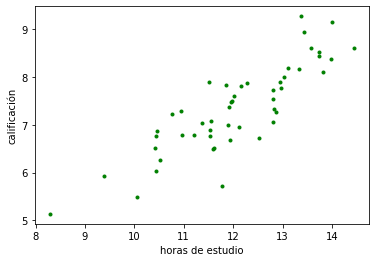

In [3]:
# se obtiene el atributo de entrada y se agrega una dimensión
x_train = np.array(df.iloc[:,1])[..., np.newaxis]
# se obtiene la salda
y_true_train = np.array(df.iloc[:,-1])[..., np.newaxis]
# graficamos
plt.plot(x_train, y_true_train, '.', color='green')
plt.xlabel('horas de estudio')
plt.ylabel('calificación')
plt.show()

Utilizamos el API [tf.data](https://www.tensorflow.org/beta/guide/data_performance) de Tensorflow que nos permite crear tuberias de procesamiento de datos flexibles y eficientes. Para nuestro ejemplo, el proceso se describe mediante los siguientes pasos:

A) Los vectores de entrada y la salida pasan a `from_tensor_slices(·)` para obtener una matriz de parejas entrada-salida.

B) Las parejas entrada-salida pasan a `shuffle(·)` para ser barajeadas.

C) La salida del paso B pasa a `batch(·)` para particionar en lotes de entrenamiento.

La siguiente figura ilustra el proceso:

![alt text](../figs/pipeline.png "Title")

In [4]:
batch_size = 8
# creamos un Dataset de los dos vectores de entrada y salida
ds = tf.data.Dataset.from_tensor_slices((x_train, y_true_train))
# se barajean
ds = ds.shuffle(len(df))
# particionamos en lotes de entrenamiento
ds = ds.batch(batch_size)

W0825 15:02:16.128530 140051829479232 deprecation.py:323] From /home/bere/.virtualenvs/cap/lib/python3.6/site-packages/tensorflow/python/data/util/random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Para ver el funcionamiento de la tubería de datos imprimimos la forma de cada lote y su primer elemento.

In [5]:
# iteramos sobre los lotes
for x, y_true in ds:
    # imprimimoos las dimensiones del atributo de entrada X y la salida Y
    print(x.shape, y_true.shape)
    # imprimimos el primer elemento de cada lote
    print(x[0].numpy(), y_true[0].numpy())

(8, 1) (8, 1)
[13.026] [7.992]
(8, 1) (8, 1)
[13.99] [8.38]
(8, 1) (8, 1)
[12.814] [7.737]
(8, 1) (8, 1)
[10.421] [6.524]
(8, 1) (8, 1)
[10.768] [7.236]
(8, 1) (8, 1)
[10.437] [6.039]
(2, 1) (2, 1)
[10.46] [6.871]


### Quiz 1

¿ Cuáles serían las dimensiones si consideraramos los dos atributos de entrada?

## Definición del modelo


In [6]:
#se define la clase RegLin que hereda de tensorflow.keras.Moldel
class RegLin(Model):

  #se define el inicializador
  def __init__(self):
    # se llama al inicializador de la clase padre
    super(RegLin, self).__init__()
    # importante: se definen las capas como atributos de la clase
    self.fc = Dense(1)

  def call(self, x):
    # se realiza inferencia y definición de arquitectura al vuelo
    return self.fc(x)

### Quiz 2

¿Cómo podríamos dibujar la regresión lineal como una red neuronal?

## Definición de la función perdida

Se define el error cuadrático medio como función de pérdida.

![alt text](../figs/ecm.png)

In [7]:
loss_fn = tf.keras.losses.MeanSquaredError() 

Se define el gradiente descendente como optimizador y se le asigna una tasa de aprendizaje.

In [8]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

## Entrenamiento

El entrenamiento de un paso del modelo se ilustra con la siguiente figura:
![alt text](../figs/model_graph.png "Title")

Realizamos el entrenamiento de nuestro modelo durante dos epocas.

In [9]:
# se crea una instacia de la clase
model = RegLin()

epochs = 2
loss_history = []
step = 0

for _ in range(epochs):
    
    for x, y_true in ds:
        
        # utilizamos tf.GradientTape() para la autodiferenciación
        # todo lo que este dentro del bloque de tape
        # se usara para la retropropagación
        with tf.GradientTape() as tape:
            # inferencia
            y_pred = model(x)
            # cómputo de pérdida
            loss = loss_fn(y_true, y_pred)
        
        # se calculan los gradientes
        gradients = tape.gradient(loss, model.trainable_variables)
        
        # se optimiza el modelo
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        print(step, loss.numpy())
        loss_history.append(loss.numpy())
        
        step += 1

0 83.66790771484375
1 38.38032531738281
2 18.23932456970215
3 10.85606575012207
4 4.825052261352539
5 2.7994279861450195
6 3.0154786109924316
7 0.47831636667251587
8 0.5141856074333191
9 0.30160146951675415
10 0.24179941415786743
11 0.20257404446601868
12 0.26961958408355713
13 0.5222456455230713


Graficamos la pérdida para ver el comportamiento durante el entrenamiento.

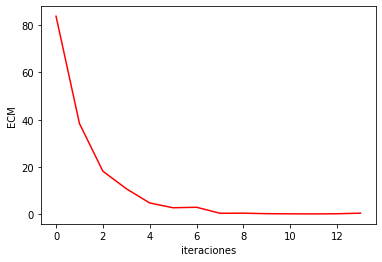

In [10]:
plt.plot(np.arange(len(loss_history)), loss_history, color='red')
plt.xlabel('iteraciones')
plt.ylabel('ECM')
plt.show()

## Inferencia

Graficamos nuestro modelo.

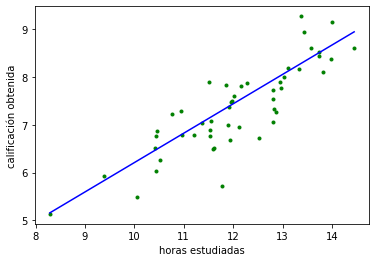

In [11]:
Y_pred = model(x_train)
plt.plot(x_train, y_true_train, '.', color='green')
plt.plot(x_train, Y_pred, color='blue')
plt.xlabel('horas estudiadas')
plt.ylabel('calificación obtenida')
plt.show()